# Crear blueprint

In [1]:
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import time
from numba import jit, njit
from numba.types import bool_, int_, float32
from math import comb
from copy import deepcopy
from tqdm import tqdm
import networkx as nx
import pandas as pd
from collections import defaultdict
from itertools import permutations

### Llegir fulls de càlcul 

In [2]:
### Open the files
fulls = 8
#n_grupo = 4 - ara no estic fent servir grups

d = {} #crea un diccionari per emmagatzemar DataFrames(taules de memòria)
D = "Dataset" #prefix del nom de les fulles — al excel es diuen Dataset1, Dataset2, ...
for i in range(0,fulls): #recorro 0...7
    d["group" + str(i)] = pd.read_excel("datasets.ods", sheet_name=D+str(i+1)) #el que al diccionari serà gorup 0, sera el meu Dataset1
    # hem assignat al diccionari: d["group0"] = <taula Dataset1> 
    #print('Read:',i, 'size', d["group" + str(i)].shape) #volem imprimir el nre de files i columnes

### Passar a matriu i binaritzem

Consideracions a tenir en compte. Primer, treiem les 3 primeres files i columnes de cada full de càlcul perquè a l'excel contenen etiquetes, no dades. En segon lloc, tenim 227 diles i 183 columnes. El que fem és forçar una matriu quadrada nre.filesxnre.files, de manera que, com la matriu inicial eren zeros, copio les columnes existets i deixo la resta plenes de zeros. Això podria donar error. NOTA: Els datasets compten la primera columna com títols.

In [3]:
## Hipermatrix M with the data (Only the synapses) 
rows = d["group" + str(i)].shape[0] - 3
columns = d["group" + str(i)].shape[1] - 3 #les tres primeres files i columnes no contenen dades

M = np.zeros((fulls,rows,columns))
for i in range(0, fulls):
    Data = d['group' + str(i)]
    M[i,:,:] = Data.iloc[3:,3:]
    
## Since we work with same number of nodes, we want them equal and square (zeros when no connections)
M_square = np.zeros((fulls, rows, rows))#creo matriu quadrada
M_square[:,:, 0:columns] = M[:,:,:] #copies les columnes existents (0..179) per deixar zeros en les restants (180..223).

## Binarization: No weights
#Lo queremos BINARIO, ignorando su peso (Luego pensar cómo se haría con el peso)
M_square_bin = np.zeros((fulls,rows,rows))
for i in range(fulls):
    for j in range(rows):
        for k in range(columns):
            if (M[i,j,k] >= 1):
                M_square_bin[i,j,k] = 1
                
Nx = rows # Number of nodes (we imposed rows == columns)


### Comprovació de l’estructura dels fulls de càlcul

Vull assegurar-me de que la neteja dels Datasets (primeres 3 files i columnes) està feta correctament. Nota: Els Datasets prenen la primera fila com un Títol  ('Pre', en aquest cas). Per tant, realment n'estic esborrant 4.

In [4]:
# inspecció ràpida d'un full de càlcul (group 7-->Dataset8)
df7 = d['group7']
print("Shape original group7:", df7.shape)
print("\nColumn names (first 12):\n", df7.columns[:12])
print("\nPrimeres 8 files i 8 columnes (sense transformar):")
print(df7.iloc[:8, :8])

Shape original group7: (227, 183)

Column names (first 12):
 Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Pre', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')

Primeres 8 files i 8 columnes (sense transformar):
  Unnamed: 0 Unnamed: 1 Unnamed: 2      Pre Unnamed: 4 Unnamed: 5 Unnamed: 6  \
0        NaN        NaN        NaN  Sensory        NaN        NaN        NaN   
1        NaN        NaN        NaN     ADFL       ADFR       ADLL       ADLR   
2        NaN        NaN        NaN      NaN        NaN        NaN        NaN   
3       Post    Sensory       ADFL        0          0          0          0   
4        NaN        NaN       ADFR        0          0          0          0   
5        NaN        NaN       ADLL        0          0          0          0   
6        NaN        NaN       ADLR        0          0          0          0   
7        NaN        NaN       AFDL      

## Escollir quin és el dataset A2

Sabem (per la informació del paper) que A2 té aproximadament 2186 arestes (edges), comprovem si el Dataset8 concorda amb aquestes dades, mirem cada dataset (recordem que group0-->Dataset1, group1-->Dataset2, ...).

NOTA: A més sospitem que el Dataset8 és el que conté les dades de A2 perquè al repo de la Teresa es pren A2 com a Blueprint fent M_square_bin[-1] que correspon a l'últim element de l'array, és a dir, M_square_bin[7], que correspon a group7--> Dataset8

### Coprovació de que Dataset8 correspon a A2

In [5]:
# Veure quants edges té cada dataset
for i in range(8):
    print(i, M_square_bin[i].sum())

0 775.0
1 986.0
2 1012.0
3 1136.0
4 1515.0
5 1525.0
6 2202.0
7 2186.0


## Guardar A2 com blueprint

Volem crear i guardar el blueprint A2 (Dataset8 = group7 = M_square_bin[-1])


In [6]:
#Seleccionem A2, és a dir, el dataset8
A2=M_square_bin[-1].copy()
#Fem comprovacions
print("A2 creat")
print("Files i columnes A2", A2.shape)
print("Arestes", int(A2.sum()))
#guardem
np.save("A2_blueprint.npy", A2)
print("Guardat com A2_blueprint")

A2 creat
Files i columnes A2 (224, 224)
Arestes 2186
Guardat com A2_blueprint


# Generar xarxes amb p i q

Ara volem comprovar el nombre d'enllaços que s'han creat (p·zeros ≈ 0.007·48000 ≈ 330–350 nous) i esborrat (q·edges ≈ 0.15·2186 ≈ 327–330 enllaços)

El que estic fent aquí no és modificar el blueprint amb errors, no reconstruir des de 0. No estic recreant la matriu probabilisticament partint d'una matriu de 0s. 
Aqui la matriu L comença tocada i només altero alguns elements.

In [7]:
#variables d'interes
L = np.load("A2_blueprint.npy")
q_paper = 0.15
p_paper = 0.007
num_networks = 2
#defineixo funcio CreateCopies
def CreateCopies(L,q,p,num_networks):
    Nx = len(L) #nombre de nodes 
    A_test = np.zeros((num_networks, Nx, Nx)) #crea un array 3D ple de zeros

    p = p_paper
    q = q_paper

   

    for k in range(num_networks):
    #    A_copy = L.copy() #deep copy de L, però no comparteixen memòria. modificar a.copy no modifica L
        for i in range(Nx):
            for j in range(Nx):
                if L[i,j] == 1:
                    # enllaç existent -> pot ser esborrat
                    if np.random.rand() >= q: #genero aleatori entre 0 i 1
                        A_test[k,i,j] = 1
                else:
                    # posició buida -> pot crear-se un fals
                    if np.random.rand() < p:
                        A_test[k,i,j] = 1
        #A_test[k,:,:] = A_copy #guardo cada xarxa k generada.
        # per cada k (ie per cada xarxa), es comença de zero fent una còpia nova i completa de L.


    #print("Xarxes generades amb p i q del paper:")
    print(A_test.shape)
    np.save("synthetic_paper.npy", A_test)
    return A_test


In [8]:
np.random.seed(11) #hem tret la llavor fixa per tenir variabilitat
for nrep in range(10):
    A_test = CreateCopies(L, q_paper, p_paper, num_networks=2)
    print('rep',nrep,'xarxa 1',np.sum(np.sum(A_test[0]-L)))
    print('rep',nrep,'xarxa 2',np.sum(np.sum(A_test[1]-L)))


(2, 224, 224)
rep 0 xarxa 1 8.0
rep 0 xarxa 2 43.0
(2, 224, 224)
rep 1 xarxa 1 17.0
rep 1 xarxa 2 50.0
(2, 224, 224)
rep 2 xarxa 1 14.0
rep 2 xarxa 2 3.0
(2, 224, 224)
rep 3 xarxa 1 64.0
rep 3 xarxa 2 -6.0
(2, 224, 224)
rep 4 xarxa 1 -21.0
rep 4 xarxa 2 48.0
(2, 224, 224)
rep 5 xarxa 1 -24.0
rep 5 xarxa 2 -9.0
(2, 224, 224)
rep 6 xarxa 1 59.0
rep 6 xarxa 2 -11.0
(2, 224, 224)
rep 7 xarxa 1 -17.0
rep 7 xarxa 2 12.0
(2, 224, 224)
rep 8 xarxa 1 -6.0
rep 8 xarxa 2 20.0
(2, 224, 224)
rep 9 xarxa 1 15.0
rep 9 xarxa 2 53.0


Si ho vull fer tal com em va dir la marta, emplenant una matriu feta de 0s seria aixi.

In [9]:

#aixo fa el mateix que la funcio CreateCopies, pero sense funcio, treure
num_networks = 2
A_test_0 = np.zeros((num_networks, Nx, Nx))
np.random.seed(1)
p=p_paper
q=q_paper

for k in range(num_networks):
    A_copy_0 = np.zeros_like(L)   # matriu tota de 0

    for i in range(Nx):
        for j in range(Nx):

            if L[i, j] == 1:
                # Enllaç existent
                if np.random.rand() < q:
                    A_copy_0[i, j] = 0        # No copio (error d'esborrat)
                else:
                    A_copy_0[i, j] = 1        # Copio
            else:
                # No enllaç
                if np.random.rand() < p:
                    A_copy_0[i, j] = 1        # Fals positiu
                else:
                    A_copy_0[i, j] = 0        # Copio (0)

    A_test_0[k] = A_copy_0
print("Xarxes generades amb p i q del paper partint d'una de 0s (recrear probabilisticament):")
print(A_test_0.shape)
np.save("synthetic_paper_0.npy", A_test_0)

Xarxes generades amb p i q del paper partint d'una de 0s (recrear probabilisticament):
(2, 224, 224)


In [10]:
# Comprovació del nombre d’enllaços final
original_edges = int(L.sum())
zeros_original = Nx*Nx - original_edges

print("Blueprint (A2) edges:", original_edges)
print("Blueprint zeros:", zeros_original)

for k in range(num_networks):
    edges_new = int(A_test[k].sum())
    print(f"\nXarxa {k}:")
    print("  Edges:", edges_new)

    # errors equivalents
    errors_esborrats = original_edges - np.sum((A_test[k] == 1) & (L == 1))
    errors_creats = np.sum((A_test[k] == 1) & (L == 0))

    print("  Errors esborrant:", errors_esborrats)
    print("  Errors creant:", errors_creats)


Blueprint (A2) edges: 2186
Blueprint zeros: 47990

Xarxa 0:
  Edges: 2201
  Errors esborrant: 318
  Errors creant: 333

Xarxa 1:
  Edges: 2239
  Errors esborrant: 299
  Errors creant: 352


## Funcions d'energia

Aquí enganxo les funcions d'energia del repositori del paper, del notebook "C-el_k4_Synthetic-No groups...", ja que son les mateixes que he de fer servir.

No considerem grups, per tant:

In [11]:
n_groups = 1 #considerem que els nodes pertanyen a un únic grup
start_groups = np.zeros(1) #indica on comença cada grup
end_groups = np.zeros(1) + Nx #indica on acaba
size_groups = np.zeros(1) + Nx

start_groups, end_groups, size_groups = start_groups.astype(int), end_groups.astype(int), size_groups.astype(int)

Aquestes son les funcions d'energia tal qual com estan al repo del paper

In [12]:
@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):

    A_1 = overlap_1 + alpha #o11 al paper
    B_1 = (Edges_L - overlap_1 + beta) #o10 al paper
    C_1 = Edges_L + alpha + beta #o1 al paper
    
    A_0 = overlap_0 + alpha #o00 al paper
    B_0 = (Edges_NoL - overlap_0 + beta) # o01 al paper
    C_0 = Edges_NoL + alpha + beta # o0 al paper
    
    #  [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(A_1)+ math.lgamma(B_1) - math.lgamma(C_1) 
    H0 = math.lgamma(A_0)+ math.lgamma(B_0) - math.lgamma(C_0) 
    
    H = -(H1 + H0)
    return H
    
    
@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0 = np.zeros((K))
    ovlp_1 = np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): 
            for c in range(0,Nx):
                p_f=int(P_inv_f[k,f]) #es tradueix l'index del bliueprint al real de 
                 #(per exemple, si el node 1 de L es el node 5 de A, p_f=5)
                p_c=int(P_inv_f[k,c])  
                valor_L, valor_A = L_f[f,c], A_f[k,p_f,p_c] #compara el valor de L i A a la posició corresponent
                
                ovlp_0[k] = ovlp_0[k] + (1-valor_L)*(1-valor_A )#mira si els zeros coincideixen a L i a A
                ovlp_1[k] = ovlp_1[k] + valor_L*valor_A #mira si els 1s coincideixen a 0 i a  A
                
                
    ovlp_1 = int(sum(ovlp_1))
    ovlp_0 = int(sum(ovlp_0)) #se sumen coincidencies en totes les observacions, resultat global
    return ovlp_0, ovlp_1
#retorna ovlp_0 (nre total de no-enllaços ben predits) i ovlp_1 (nre total d'enllacos ben predits)

@jit(nopython=True) # The blueprint is the average of the observations (taking into account the mapping)  
def L_wiring(A_f, P_inv_f): #enlaces que aparecen en la mayoría de observaciones
    #A_f:  te la forma KxNxNy, on K és el nre de xarxes observades
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0] 
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
                #per cada posicio (ij) mira en les K xarxes la posicio que li correspon al blueprint (equivalent segons el mapping)
                p1 = int(P_inv_f[k,i]) # Mapping of the observations
                p2 = int(P_inv_f[k,j]) # Mapping of the observations
                L_new_f[i,j] += A_f[k,p1,p2] #sumo les connexions existents a la posició equivalent en les K xarxes observades
            valor_lnew=1/K* L_new_f[i,j] #fa la mitjana de connexions existents en les K xarxes observades
            L_new_f[i,j] = round( valor_lnew ) #redondeja al valor més proper
            # If valor_lnew = 0, L=0 (we could establish L=1, but it is more probable to not have a connection)
            #L_ij=1--> a la majoria de les k observacions alineades hi ha enllaç aquí
            # L_ij=0--> a la majoria de les k observacions alineades no hi ha enllaç aquí 
    return L_new_f


#### Some algorithm for sorting
@jit(nopython=True)
def partition(array,  etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot] 

    return pivot
@jit(nopython=True)
def quicksort(array, etiquetas, begin=0, end=None):
    if end is None:
        end = len(array) - 1
    if begin >= end: #To end
        return
    pivot = partition(array,  etiquetas, begin, end)
    
    #Order right and left
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array,  etiquetas, pivot+1, end)
    
@njit 
# We inizialise the algorithm sorting by node degree, but also taking into account the group labels
def permu_groups(L_f, A_f, start_f): 
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    
    # Mappings
    P_f = np.zeros((K,Nx)) #Mapping from L to A
    P_inv_f = np.zeros((K,Nx)) #Mapping from A to L
    P_new = np.zeros((K,Nx))
    
    # First we order the blueprint and after the observations
    # Blueprint:
    orden_L=np.zeros((Nx))
    for i in range(Nx):
        b=np.nonzero(L_f[i,:])
        orden_L[i] = b[0].size
        
    array_L = np.arange(Nx) #For the labels 
    quicksort(orden_L, array_L)
    
    # Now according to the group label
    array_L_labels = np.zeros((Nx))
    group_number = np.zeros((N_groups))
    for i in range(Nx):
        n_type = 0
        #Group
        while ( (array_L[i] >= start_f[n_type]) and (n_type < N_groups)):
            n_type += 1
       
        grupo = int(n_type-1)
        g = int(start_f[grupo])
        array_L_labels[g + int(group_number[grupo])] = array_L[i]
        group_number[grupo] += 1

    #Observations: 
    for i in range(0,K):
        orden_A = np.zeros((Nx))
        for i_orden in range(Nx):
            b = np.nonzero(A_f[i,i_orden,:])
            orden_A[i_orden] = b[0].size

        array_A = np.arange(Nx) #For the labels 
        quicksort(orden_A, array_A)
            
        # Now according to the group label
        array_A_labels = np.zeros((Nx))
        group_number = np.zeros((N_groups))
        
        for i_g in range(Nx):
            n_type = 0
            while ( (array_A[i_g] >= start_f[n_type]) and (n_type < N_groups) ):
                n_type += 1

            grupo = int(n_type-1)
            g = int(start_f[grupo])
            array_A_labels[ g + int(group_number[grupo])] = array_A[i_g]
            group_number[grupo] += 1
    

    # Now ordered together both label array  array_L = [0,1,2,3...]
        array_A_labels = array_A_labels[np.argsort(array_L_labels)]
        P_f[i,:] = array_A_labels
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy() 
    P_todo[1,:,:] = P_inv_f.copy()

    return P_todo

 

## Generar 10 mostres

El que vull fer ara és agafar la blueprint i les dues xarxes generades i aplicar la identitat i les funcions d'energia. Després, fer un shuffle i aplicar energies. Generar 10 i fer historigrama

### pas 1

De moment agafo la latent, i les dues xarxes generades amb cert error i aplico identitat i funcions d'energia

In [13]:
np.random.seed(111) #fixo la llavor de les xarxes random generades pq sino cada execucio em genera xarxes diferents
q_paper, p_paper = 0.8, 0.1 #0.15, 0.007
p_paper = q_paper * np.sum(np.sum(L))/(Nx*Nx - np.sum(np.sum(L)))
print("q_paper =", q_paper, " p_paper =", p_paper)
#carrego fitxers
L = np.load("A2_blueprint.npy")                   # blueprint guardada
num_networks = 2
Nx = L.shape[0]
A_test = CreateCopies(L,q_paper,p_paper, num_networks=num_networks)         # 2 xarxes generades
print("A_test num 1s :", np.sum(np.sum(A_test[0])),np.sum(np.sum(A_test[1])))

# Construir Ao a enters i identitat (P_inv_id)
Ao_enters = A_test.astype(int)       # aqui convertim a int per si de cas havia quedat amb floats després de fer rand
P_inv_id = np.tile(np.arange(Nx), (num_networks, 1)) 
#tile empila num_networks vegades la matriu [0,1,2,...,Nx-1] perque cada xarxa tingui la seva pròpia matriu identitat
#Cridar L_wiring 
print("Aplico L_wiring")
L_nova = L_wiring(Ao_enters, P_inv_id)
print("L_nova num 1s :", np.sum(np.sum(L_nova)),np.sum(np.sum(L)))
 

#Cridar overlap_total_prob amb la blueprint original (L) i Ao_stack amb identitat
print("Aplico overlap_total_prob")
ovlp0_identity, ovlp1_identity = overlap_total_prob(L_nova, Ao_enters, P_inv_id)
print("ovlp0_identity =", ovlp0_identity)
print("ovlp1_identity =", ovlp1_identity) 

#aplico hamiltonian_prob
# Calcular nombre d'enllaços i zeros a la blueprint
Nx = L_nova.shape[0]
Edges_L = num_networks* int(L_nova.sum()) # nombre de 1s de la blueprint
Edges_NoL = num_networks*Nx*Nx - Edges_L    # nombre de 0s

print("Edges_L  =", Edges_L)
print("Edges_NoL =", Edges_NoL)

#Parametres alpha i beta
alpha = 1.0
beta  = 5.0 #1.0
print("alpha =", alpha, " beta =", beta)

# Aplicar hamiltonian_prob
print("Aplico hamiltonian_prob")
H_identity = hamiltonian_prob(
    Edges_NoL,
    Edges_L,
    ovlp0_identity,
    ovlp1_identity,
    alpha,
    beta
)

print("H_identity =", H_identity)

#Guardar resultats, descomento quan estig segura que funciona
#np.save("H_identity.npy", np.array(H_identity))
#np.save("ovlp0_identity.npy", np.array(ovlp0_identity))
#np.save("ovlp1_identity.npy", np.array(ovlp1_identity))

print("PAS 1 complet correctament.")


q_paper = 0.8  p_paper = 0.03644092519274849
(2, 224, 224)
A_test num 1s : 2141.0 2171.0
Aplico L_wiring
L_nova num 1s : 160.0 2186.0
Aplico overlap_total_prob
ovlp0_identity = 96040
ovlp1_identity = 320
Edges_L  = 320
Edges_NoL = 100032
alpha = 1.0  beta = 5.0
Aplico hamiltonian_prob
H_identity = 16815.346650217012
PAS 1 complet correctament.


Apliquem shuffles per generar xarxes random

In [14]:

n_shuffles = 1000
H_shuffle = []

for t in range(n_shuffles):
    # Generar P_inv aleatori
    P_inv_shuffle = np.array([np.random.permutation(Nx) for _ in range(num_networks)], dtype=np.int64)
    #fem servir random permutations enlloc de shuffle perque shuffle modifica l'array original
    # mateix pipeline que per P_inv_id
    L_sh = L_wiring(Ao_enters, P_inv_shuffle)
    ovlp0_sh, ovlp1_sh = overlap_total_prob(L_sh, Ao_enters, P_inv_shuffle)
    print("ovlp0_sh =", ovlp0_sh, " ovlp1_sh =", ovlp1_sh)
    Nx = L_sh.shape[0]
    Edges_L_sh = num_networks* int(L_sh.sum()) # nombre de 1s de la blueprint
    Edges_NoL_sh = num_networks*Nx*Nx - Edges_L_sh    # nombre de 0s
    H_sh = hamiltonian_prob(Edges_NoL_sh,  Edges_L_sh, ovlp0_sh, ovlp1_sh, alpha, beta)

    H_shuffle.append(H_sh) #guardar valors
    print(f"Shuffle {t+1}/{n_shuffles}  —  H = {H_sh:.6f}")

print("H_identity =", H_identity)
print("H_shuffle (lista) =", H_shuffle)
np.save("H_shuffle.npy", np.array(H_shuffle))


ovlp0_sh = 96040  ovlp1_sh = 184
Shuffle 1/1000  —  H = 17248.355181
ovlp0_sh = 96040  ovlp1_sh = 202
Shuffle 2/1000  —  H = 17191.392690
ovlp0_sh = 96040  ovlp1_sh = 186
Shuffle 3/1000  —  H = 17242.031869
ovlp0_sh = 96040  ovlp1_sh = 190
Shuffle 4/1000  —  H = 17229.380792
ovlp0_sh = 96040  ovlp1_sh = 162
Shuffle 5/1000  —  H = 17317.809748
ovlp0_sh = 96040  ovlp1_sh = 174
Shuffle 6/1000  —  H = 17279.948990
ovlp0_sh = 96040  ovlp1_sh = 172
Shuffle 7/1000  —  H = 17286.263113
ovlp0_sh = 96040  ovlp1_sh = 164
Shuffle 8/1000  —  H = 17311.503670
ovlp0_sh = 96040  ovlp1_sh = 194
Shuffle 9/1000  —  H = 17216.723849
ovlp0_sh = 96040  ovlp1_sh = 188
Shuffle 10/1000  —  H = 17235.707069
ovlp0_sh = 96040  ovlp1_sh = 146
Shuffle 11/1000  —  H = 17368.197117
ovlp0_sh = 96040  ovlp1_sh = 210
Shuffle 12/1000  —  H = 17166.038993
ovlp0_sh = 96040  ovlp1_sh = 178
Shuffle 13/1000  —  H = 17267.316066
ovlp0_sh = 96040  ovlp1_sh = 188
Shuffle 14/1000  —  H = 17235.707069
ovlp0_sh = 96040  ovlp1_sh = 

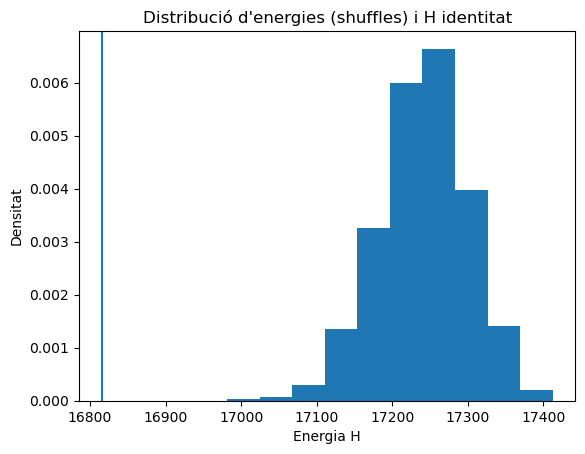

In [15]:
import matplotlib.pyplot as plt

plt.hist(H_shuffle, bins=10, density=True)
plt.axvline(H_identity)

plt.xlabel("Energia H")
plt.ylabel("Densitat")
plt.title("Distribució d'energies (shuffles) i H identitat")

plt.show()
